## Miles Roberts and Joshua Kaste ear segmentation

In [16]:
#The following code snip-it reads any file from the internet and saves it to your local directory.
from urllib.request import urlopen, urlretrieve
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
from skimage.morphology import remove_small_holes
from skimage.morphology import remove_small_objects
from skimage import exposure #histogram equalization
import colorsys #To convert to rbg to hsv color space
import matplotlib.colors as colors
import os #For getting list of files
from scipy import ndimage #For performing erosion and dilation

#Get list of photo names
fileNames = ['IMG_8277.jpg','IMG_8280.jpg','IMG_8333.jpg','IMG_8338.jpg','IMG_8342.jpg','IMG_8343.jpg','IMG_8312.jpg','IMG_8284.jpg','IMG_8349.jpg']

#Define thresholds for isolating tray in photos
hmin = -0.01
hmax = 1.01
smin = -0.01
smax = 0.05
vmin = -0.01
vmax = 1.01

#Function for calculating run lengths in a binary array
#function is from: https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

conversion_dict = {}        

#Loop over photos and crop them
for fileName in fileNames:
    #Load picture
    im = imread(fileName)
    
    #Histogram equalization
    im2 = exposure.equalize_hist(im)
    
    #convert from rgb to hsv color space, pull out matrices
    hsv = colors.rgb_to_hsv(im2)
    h = hsv[:,:,0]; #hue matrix
    s = hsv[:,:,1]; #saturation matrix
    v = hsv[:,:,2]; #value matrix (i.e. brightness)
    
    #Convert to binary image based on thresholds
    # trick because the color space wraps
    if hmin > hmax:
        b_img = (h > hmin) | (h < hmax)
    else:
        b_img = (h > hmin) & (h < hmax);
    b_img = (b_img & 
        (s > smin) & (s < smax) & 
        (v > vmin) & (v < vmax));
    
    #Clean up binary image with erosion and dilation
    b4 = skimage.morphology.remove_small_holes(b_img,area_threshold=50000) # removing holes
    b5 = skimage.morphology.remove_small_holes(b4,area_threshold=10000) # removing holes again
    b6 = skimage.morphology.remove_small_holes(b5,area_threshold=10000) # removing even more holes
    b8 = remove_small_objects(b6,min_size=50000) #removing any chaff 
    
    #Label objects in binary image
    lab, num_features = ndimage.measurements.label(b8)
    
    #Sum togther rows and columns of binary array to determine which pixels represent the tray (labeled as object 1) 
    a1 = np.sum(lab==1,axis=1)
    a0 = np.sum(lab==1,axis=0)
    
    #Convert binary arrays to logical arrays. Now just need to find longest run of False elements in each array
    al0 = a0 > min(a0)
    al1 = a1 > min(a1)
    
    #Calculate run lengths
    runLengths0 = rle(al0)
    runLengths1 = rle(al1)
    
    #Focus on columns
    ##Find index of where longest run begins
    runs0 = runLengths0[0]
    positions0 =  runLengths0[1]
    maxRun0 = max(runs0)
    result = np.where(runs0 == maxRun0)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startCol = positions0[index].tolist()[0][0] - 120
    endCol = startCol + maxRun0 + 240
    
    #Focus on rows
    ##Find index of where longest run begins
    runs1 = runLengths1[0]
    positions1 =  runLengths1[1]
    maxRun1 = max(runs1)
    result = np.where(runs1 == maxRun1)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startRow = positions1[index].tolist()[0][0] - 120
    endRow = startRow + maxRun1 + 240
    
    # calculate conversion factor by relating run lengths identified above (maxRun0 is columns and maxRun1 is rows)
    # and updating a dictionary, called conversion_dict, with a fileName to conversion factor key:value relationship.
    # Note that we don't want to overwrite our files, so we create a 'finalFilename' ahead of time, use that to
    # create the dictionary, and then use it to also export our new images. Additionally, we take the average of the
    # pixel-to-cm relationships for extra robustness
    
    finalFilename = "testing_" + fileName
 
    top_bottom_in_cm = 38.5
    left_right_in_cm = 29.4
    conversion_top_bottom = top_bottom_in_cm / maxRun0
    conversion_left_right = left_right_in_cm / maxRun1
    average_conversion = (conversion_top_bottom + conversion_left_right) / 2
    new_addition = {finalFilename:average_conversion}
    conversion_dict.update(new_addition)
    
    #Crop and save image
    im3 = im2[startRow:endRow,startCol:endCol]
    imsave(finalFilename, im3)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8277.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8280.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8333.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8338.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8342.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8343.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8312.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8284.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


testing_IMG_8349.jpg


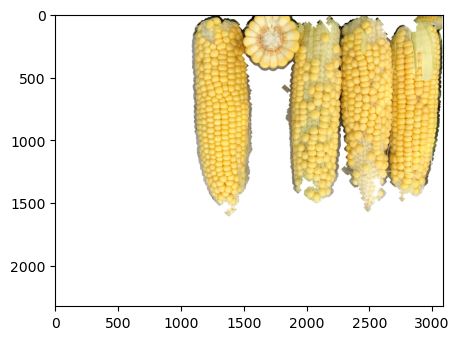

In [3]:
copy = img.copy()
copy[~best] = 255
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(copy)

## Rei Doko's segmentation

In [11]:
from skimage.color import rgb2lab
from skimage import filters

def filter_1(image, hsv_image, lab_image):
    t1=filters.threshold_isodata(hsv_image[:,:,0])
    t2=filters.threshold_isodata(hsv_image[:,:,1])
    t3=filters.threshold_isodata(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    return binary_image

def filter_2(image, hsv_image, lab_image):
    t1=filters.threshold_minimum(hsv_image[:,:,0])
    t2=filters.threshold_minimum(hsv_image[:,:,1])
    t3=filters.threshold_minimum(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    binary_image = morphology.remove_small_objects(binary_image, 70000)
    return binary_image

def filter_3(image, hsv_image, lab_image):
    t1=filters.threshold_mean(image[:,:,0])
    t3=filters.threshold_mean(image[:,:,2])
    binary_image = (image[:,:,0] > t1) & (image[:,:,2] < t3)
    binary_image = morphology.remove_small_objects(binary_image, 70000)
    return binary_image

def filter_4(image, hsv_image, lab_image):
    t1=filters.threshold_mean(lab_image[:,:,0])
    t2=filters.threshold_mean(lab_image[:,:,1])
    t3=filters.threshold_mean(lab_image[:,:,2])
    binary_image = (lab_image[:,:,0] < t1) & (lab_image[:,:,1] > t2) & (lab_image[:,:,2] > t3)
    binary_image = ndimage.binary_dilation(binary_image, iterations=3)
    binary_image = morphology.remove_small_objects(binary_image, 30000)
    binary_image = ndimage.binary_erosion(binary_image)
    return binary_image

def filter_5(image, hsv_image, lab_image):
    t1=filters.threshold_yen(hsv_image[:,:,0])
    t2=filters.threshold_yen(hsv_image[:,:,1])
    t3=filters.threshold_yen(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    return binary_image

def filter_6(image, hsv_image, lab_image):
    t1=filters.threshold_sauvola(lab_image[:,:,1])
    t2=filters.threshold_sauvola(lab_image[:,:,2])
    t3=filters.threshold_sauvola(hsv_image[:,:,0])
    binary_image = (lab_image[:,:,1] < t1) & (lab_image[:,:,2] < t2) & (hsv_image[:,:,0] > t3)
    binary_image = ndimage.binary_erosion(binary_image, iterations=3)
    binary_image = ndimage.binary_dilation(binary_image, iterations=2)
    binary_image = morphology.remove_small_objects(binary_image, 20000)
    return binary_image

def filter_7(image, hsv_image, lab_image):
    lab_image = rgb2lab(image)
    hsv_image = rgb2hsv(image)
    t1=filters.threshold_li(lab_image[:,:,2])
    t2=filters.threshold_li(hsv_image[:,:,0])
    t3=filters.threshold_li(hsv_image[:,:,1])
    t4=filters.threshold_yen(lab_image[:,:,0])
    binary_image = (lab_image[:,:,2] > t1) & (hsv_image[:,:,0] < t2) & (hsv_image[:,:,1] > t3) & (lab_image[:,:,0] > t4)
    binary_image = morphology.area_closing(binary_image, area_threshold=512)
    binary_image = morphology.remove_small_objects(binary_image, 4096)
    return binary_image

def multimask_support(image, filter_functions):
    support = np.zeros((image.shape[0],image.shape[1]))
    hsv_image = rgb2hsv(image)
    lab_image = rgb2lab(image)
    for ff in filter_functions:
        support += ff(image, hsv_image, lab_image)
    return support

filter_functions = [filter_1, 
                    filter_2, 
                    filter_3, 
                    filter_4, 
                    filter_5, 
                    filter_6,
                    filter_7]

support = multimask_support(image, filter_functions)

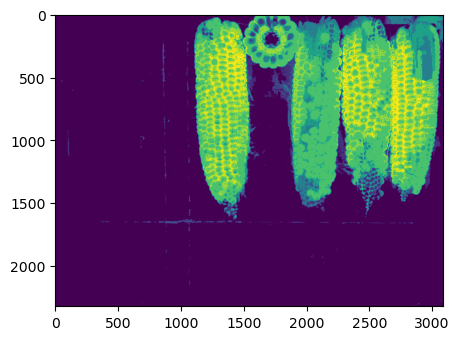

In [12]:
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(support)

In [42]:
maybe_better = best | (support > 1)
maybe_better1 = morphology.area_closing(maybe_better, area_threshold=40000)
maybe_better2 = morphology.remove_small_objects(maybe_better1, 10000)
maybe_better3 = morphology.remove_small_holes(maybe_better2, 125000)

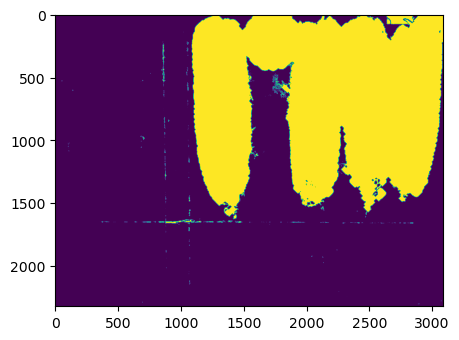

In [46]:
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(maybe_better)

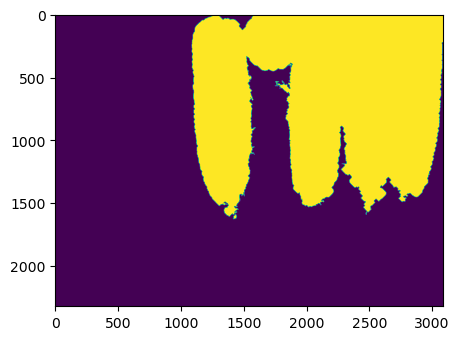

In [47]:
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(maybe_better3)

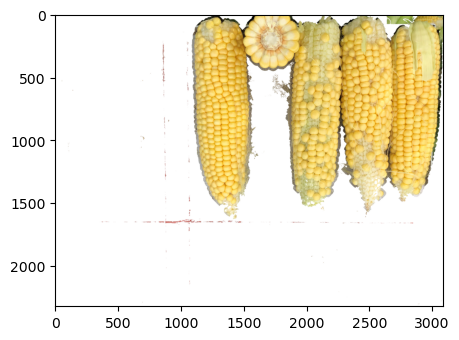

In [48]:
copy = image.copy()
copy[~maybe_better] = 255
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(copy)

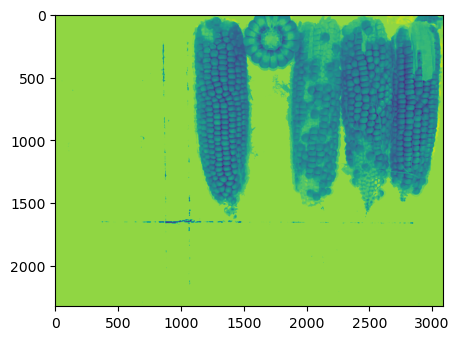

In [49]:
from plantcv import plantcv
# Convert RGB to LAB and extract the Blue channel

    # Input:
    #   rgb_img - RGB image data 
    #   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b2 = plantcv.rgb2gray_lab(rgb_img=copy, channel='b')
    # Threshold the blue image

fig = plt.figure(figsize=(5,5), dpi=100);
plt.imshow(b2)

    # Fill small objects (optional)
#b_fill = plantcv.fill(b_thresh, 10)

# Kernel Mask

### Total blank fill = total area of ear - total area of kernels
#### Challenging to get total area of ear because of the tips of the ears being in a similar colorspace as the background tray
#### Reicreated a great mask for pulling out the ears of corn which is shown above which we can use to get the total area of the ear
#### Below we show the mask used to pull out just the kernels using PlantCV

In [1]:
pip install plantcv

In [21]:
from plantcv import plantcv

# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
plantcv.params.debug = "plot"



#filename = ('cropped_IMG_8248.jpg')
fileNames = ['testing_IMG_8248.jpg', 'testing_IMG_8270.jpg', 'testing_IMG_8275.jpg', 'testing_IMG_8277.jpg','testing_IMG_8280.jpg', 'testing_IMG_8284.jpg', 'testing_IMG_8291.jpg', 'testing_IMG_8302.jpg', 'testing_IMG_8305.jpg ' , 'testing_IMG_8312.jpg', 'testing_IMG_8333.jpg','testing_IMG_8338.jpg', 'testing_IMG_8339.jpg', 'testing_IMG_8340.jpg', 'testing_IMG_8342.jpg','testing_IMG_8343.jpg','testing_IMG_8312.jpg', 'testing_IMG_8349.jpg']


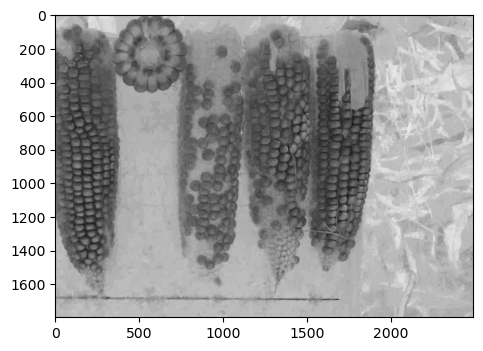

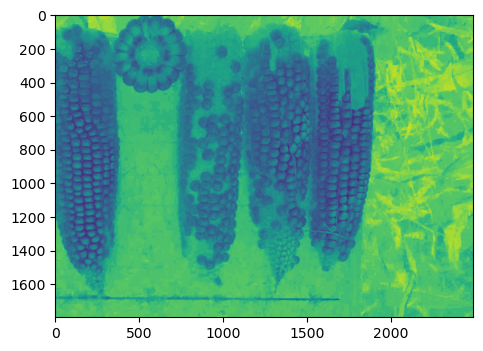

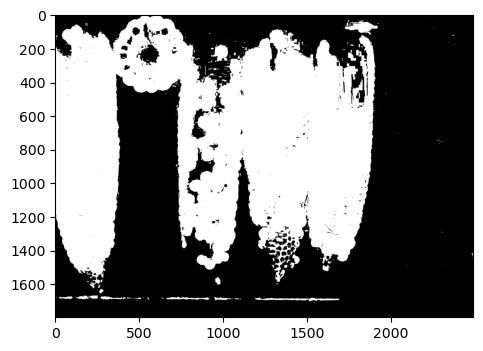

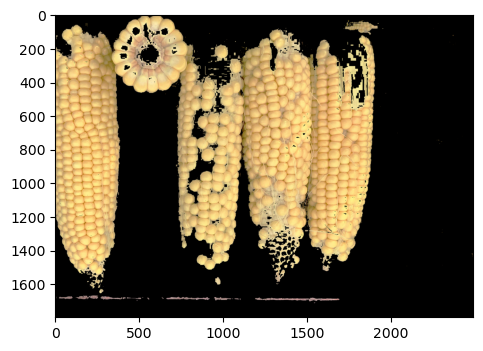

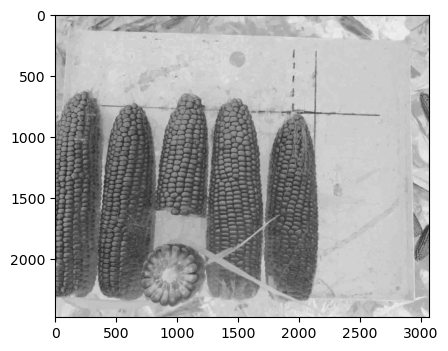

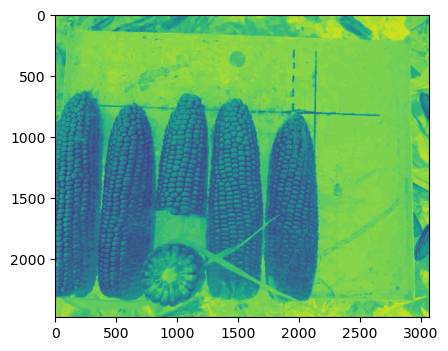

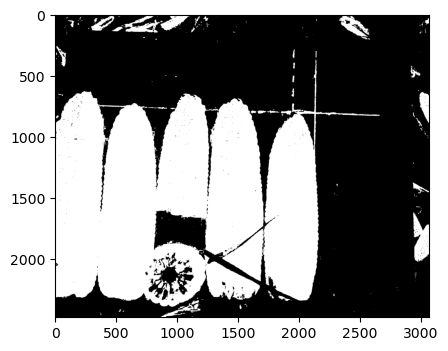

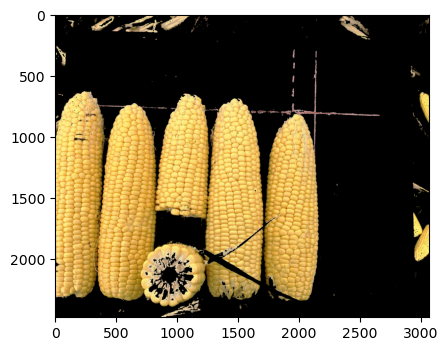

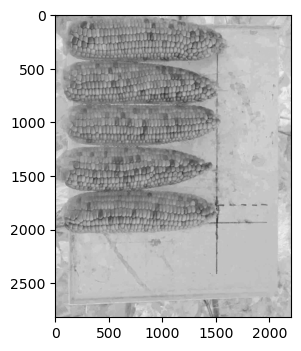

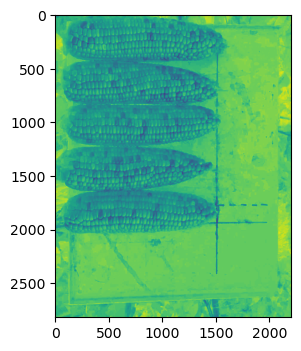

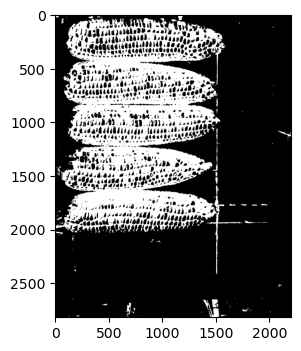

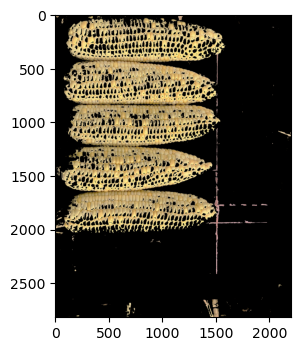

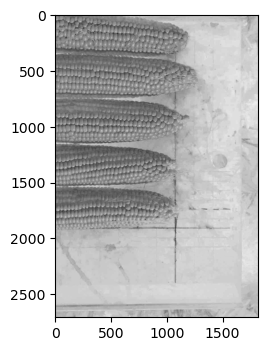

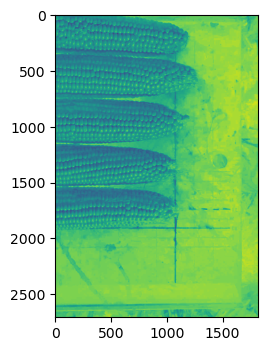

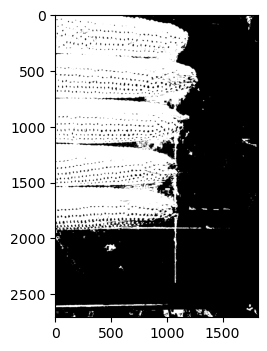

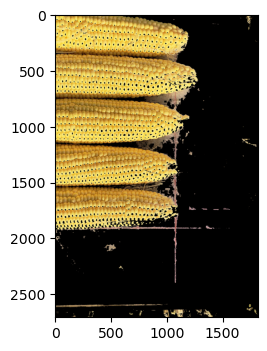

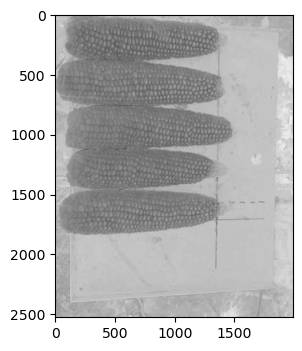

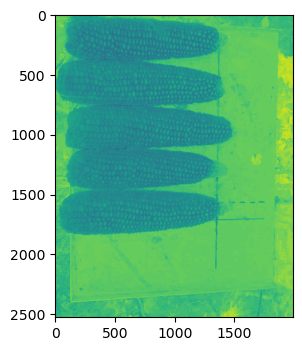

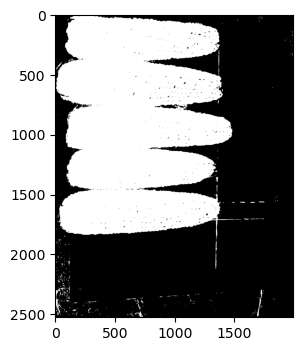

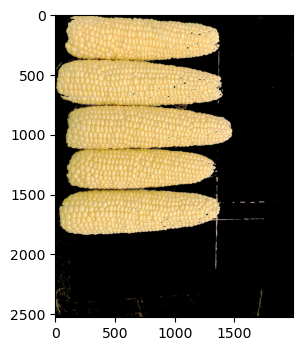

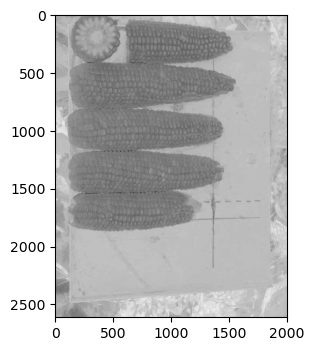

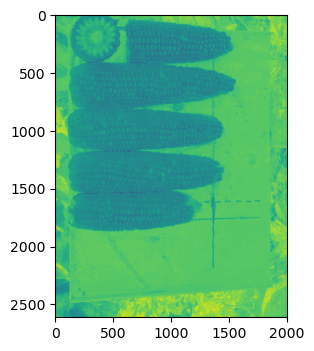

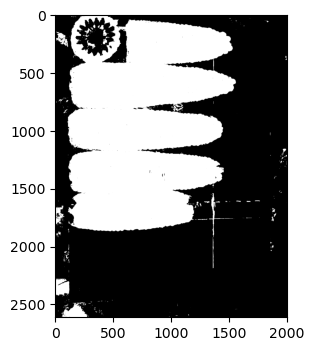

ValueError: Could not find a format to read the specified file in single-image mode

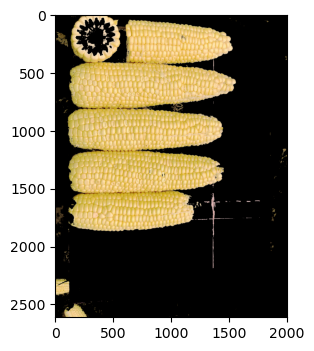

In [22]:
#loop for going through cropped images and applying kernel mask
for f in fileNames:
    im = imread(f)
    b = plantcv.rgb2gray_lab(rgb_img=im, channel='b')
    plt.imshow(b)
    
    b_thresh = plantcv.threshold.binary(gray_img=b, threshold=115, max_value=255, 
                                    object_type='dark') #110-120 threshold value works best
    plt.imshow(b_thresh)
    masked_b_final = plantcv.apply_mask(img=im, mask=b_thresh, mask_color='black') #kernelmask
    plt.imshow(masked_b_final)
   

   